# Topic 2.6: (Un)supervised learning, PCA

This notebook combines theory with code exercises to support the understanding of (un)supervised machine learning and principal component analysis in computer-aided diagnosis. **Please note:** Cells in this notebook must be executed _in order_ as the code often relies on cells run above it!

**Contents:** <br>

1. [Supervised vs. unsupervised learning](#supervised_unsupervised_learning)<br>
2. [Principal component analysis (theory)](#pca)<br>

    2.1 [Motivation](#pca_motivation)<br>

    2.2 [Basics of PCA](#pca_basics)<br>

    2.3 [Dimensionality reduction using PCA](#pca_dim_reduction)<br>

    2.4 [Intuitive interpretations and principal components](#pca_intuitive)<br>


3. [Principal component analysis (exercises)](#pca_exercises)


In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

<a id=supervised_unsupervised_learning></a>

<div style="float:right;;margin:-5px 5px"><img src="../reader/assets/read_ico.png" width="42" height="42"></div>

## 1. Supervised vs. unsupervised learning

While supervised machine learning (e.g. classification or regression) serves to develop a predictive model based on input and output data (i.e. ground truth, labels), unsupervised machine learning (e.g. clustering or dimensionality reduction) utilizes machine learning algorithms to cluster unlabelled data by finding hidden patterns without the need for manual human intervention. 

<center width="100%"><img src="../reader/assets/machine_learning_diagram.png" width="800"></center>
<div style="font-size:8px;"> Figure from <a href="http://www.cognub.com/index.php/cognitive-platform/">Cognitive platform</a></div>

Supervised learning requires a lot of known transformations for training and it is necessary to use ground truth (labels) to calculate the loss. Supervised machine learning methods can either be *fully supervised* (e.g. 2D FlowNet or 3D U-net, mostly patch-based; see [generation of ground truth transformations](https://pubmed.ncbi.nlm.nih.gov/30371358/) and [large deformation diffeomorphic metric mapping - LDDMM](https://pubmed.ncbi.nlm.nih.gov/28705497/)) or *weakly supervised*, utilizing overlap between segmentations or a similarity metric combined with ground truth (e.g. registration between ultrasound and MRI images using [convolutional neural networks - CNNs](https://arxiv.org/abs/1804.11024) or [generative adversarial networks - GANs](https://arxiv.org/abs/1807.03361)).

Despite its relative computational complexity due to a high volume of traning data, unsupervised learning is widely used in computer vision tasks (for visual perception and object recognition) as well as in medical imaging to guide radiologists and pathologists towards accurate diagnoses. There is no need for ground truth (labels); instead, unsupervised methods often use a spatial transformer layer. A spatial transformer is a learnable module that explicitly allows for spatial manipulation of data within a given network. They are differentiable, modularizable for existing neural networks and serve for active transformation of feature maps.

**Examples of unsupervised machine learning methods:**

1. [Vairational autoencoders](https://arxiv.org/abs/1804.07172)<br>
2. [Generative adversarial networks (GANs)](https://arxiv.org/abs/1807.07349)<br>
3. Multi-scale methods:<br>

    3.1 [RegNet](https://link.springer.com/chapter/10.1007/978-3-319-66182-7_27)<br>

    3.2 [ConvNet](https://arxiv.org/abs/1809.06130)<br>
    
    3.3 [pgCNN](https://pubmed.ncbi.nlm.nih.gov/31751269/)<br>
    
    3.4 [HoVer-Net](https://arxiv.org/abs/1812.06499)<br>


4. [VoxelMorph (U-net)](https://arxiv.org/abs/1809.05231)<br>
    
    4.1 [Cycle-consistent VoxelMorph](https://link.springer.com/chapter/10.1007/978-3-030-32226-7_19)<br>

<a id=pca></a>

<div style="float:right;;margin:-5px 5px"><img src="../reader/assets/read_ico.png" width="42" height="42"></div>

## 2. Principal component analysis (theory)
This section is meant to teach you about **principal component analysis** (PCA), a technique that is commonly used in medical image analysis to reduce the dimensionality of data (for example, features for a classification or segmentation task). 

We will begin with some motivation *why* PCA (and dimensionality reduction in general) is useful. Next, we will show PCA applied to a simple Gaussian dataset, and then to the nuclei dataset.

<a id=pca_motivation></a>

### 2.1 Motivation

The ultimate goal of any classification/segmentation technique is to use training data to make accurate predictions about future, unlabeled data. In other words, the goal is to *generalize* well to new data. This can be achieved by many different choices for classifiers and many different combinations of features. For example, when tasked with predicting the systolic blood pressure of a patient given some clinical data, we could use many different clinical values: the low-density lipoprotein (LDL) blood levels of the patient, their high-level lipoprotein (HDL), but also their age, weight and height.

Choosing which combination of features to use for a classifier is a non-trivial task, for a variety of reasons:

- For most complex tasks, it is inherently unclear what number of features is 'enough'.<br>
- It may not always be intuitive what features are actually discriminatory between your classes.<br>
- Increasing the number of features may actually decrease the performance of the classifier.

<center width="100%"><img src="../reader/assets/dimensionality_vs_performance.png" width="500"></center>

<div style="text-align: center"> <b>Figure 2.1.1:</b> As dimensionality (the number of features) increases, a classifier's performance can increase until some optimum. Further increasing the dimensionality for the same amount of training samples can result in a decrease in classifier performance. </div>

### *Curse of dimensionality*

It is worth elaborating on the last point: increasing the number of features may inadvertedly lower classifier performance. This is because of something called the *curse of dimensionality*. We can illustrate the curse of dimensionality with a simple example, where we try to classify pictures of dogs from cats using a linear classifier. 

In the image below, we show how the feature space of the classifier grows by adding one new feature (dimension) at a time. You can image that we might begin by classifying dogs from cats by their color, but we find that this doesn't offer a linear seperability of our dataset (there is no one line we can draw that perfectly seperates the two animals). We see the same for two features (e.g. color and size). However, when we use three features (e.g. color, size and weight), we *can* linearly seperate the two classes, thus giving us perfect classification accuracy!

<center width="100%"><img src="../reader/assets/1D_2D_3D_problem.png" width="900"></center>

<div style="text-align: center"> <b>Figure 2.2.2:</b> The more features we use, the higher the likelihood we can seperate the classes with a hyperplane. </div>

While it looks like adding more features has improved classification performance, **this is actually not the case**. Consider the 'density' of all of the training samples (represented by cat/dog icons) within the feature space: as the number of dimensions goes up, the feature space becomes increasingly sparse. As you might intuitively feel, it is much easier to find a hyperplane that splits two classes perfectly in a sparse feature space than in a very densely filled feature space - there are simply far less constraints on what shape the hyperplane needs to take on. In fact, if you were to take an infinite amount of features, the probability of a training sample laying on the wrong side of a hyperplane would become infinitely small and your classification performance on the training samples would be perfect.

In this way, the curse of dimensionality causes **overfitting** on the training set: the learned hyperplane does not reflect actual real-world differences between cats and dogs (the test set), but instead reflects the appearance of individual cats and dogs that just happen to appear in our training set. In this instance, a much better choice would be to do linear classification on two features: while performance on the training set would be lower, the model would *generalize* much better to the new, unseen data of the test set.

<div style="float:right;;margin:-5px 5px"><img src="../reader/assets/read_ico.png" width="42" height="42"></div>

<a id=pca_basics></a>

### 2.2 Basics of PCA

After the cat/dog example, we are left with an obvious question: "if we shouldn't use too many features due to the curse of dimensionality, which features *should* we use?" PCA is often used to determine which features are most suitable for a classification problem. We begin by illustrating the basic principles of PCA on a Gaussian dataset.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import sys

def plot_data(X, title = None, xlabel = None, ylabel = None, ax = None):
    
    # If no pre-existing axis given, make new plot
    if ax is None:
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(111)
        ax.grid()
    
    # Plot and format figure
    ax.scatter(X[:,0], X[:,1])
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_title(title, fontweight = 'bold')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
def draw_vector(start, end, ax = None):
    ax = ax or plt.gca()
    arrowprops = dict(arrowstyle = '->',
                      linewidth = 4,
                      shrinkA = 0, shrinkB = 0)
    ax.annotate('', end, start, arrowprops = arrowprops) # Draw vector from coords (start) to (end)

Our dataset is defined as an $M$-by-2 matrix $\mathbf{X}$ containing $M$ points sampled from a two dimensional Gaussian
$\mathcal{N}$ with $\mu_1 = 0, \mu_2 = 0$  
and a covariance matrix $\mathbf{\Sigma} = \begin{pmatrix} 2 & 1\\ 1 & 2 \end{pmatrix}$. Because of the covariance matrix, there is a positive skew upwards when plotting the data.

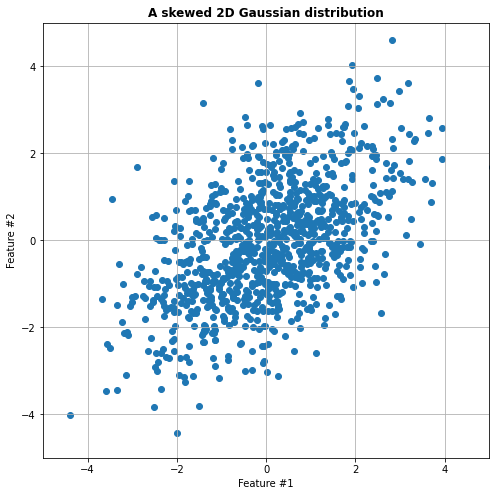

In [4]:
n_samples = 1000
X = np.random.multivariate_normal([0,0], [[2,1], [1,2]], n_samples) # Make 2D gaussian dataset
plot_data(X, "A skewed 2D Gaussian distribution", "Feature #1", "Feature #2")

PCA works by finding the 'principal components' of an $N$-dimensional dataset (here $N$ = 2). One reasonable way to think of principal components is that they are the directions in which the dataset shows the most variation, i.e. the largest spread in values. Typically, these directions of large variance are the interesting parts of the dataset: imagine a dataset with 100 features, 98 of which barely have any spread, and 2 of which show large amounts of variance. You can intuitively imagine that these 2 features, because of their variance, must have some power to discriminate between classes. 

Principal components are always orthogonal to one another and together form a new basis that we can use to transform the data. As a result of the transformation, the data will be linearly uncorrelated, meaning the covariance matrix will be diagonal: $\mathbf{\Sigma} = \begin{pmatrix} a & 0\\ 0 & b \end{pmatrix}$, with $\{a, b\} \geq 0$. This also means that the directions of greatest variances are now aligned with the axes: the first coordinate is now the first principal component, the second coordinate is the second principal component, and so on.

### *Mathematical background*

The process begins by centering the data $X$ ($M$ samples by 2 features) around the origin by subtracting the means of each variable from that column:
\begin{equation}
\mathbf{\hat{X}} = \mathbf{X} - \mathbf{\bar{X}} 
\end{equation}

We can find the principal components for the matrix $\mathbf{\hat{X}}$ by calculating its covariance matrix $\mathbf{\Sigma}$ and calculating the corresponding eigenvalues and eigenvectors of $\mathbf{\Sigma}$. The eigenvectors represent the principal components of the data and the eigenvalues represent the amount of variance explained by that principle component (proving that this is the case is outside of the scope of this course). 

We can calculate the covariance matrix with the following formula:
\begin{equation}
\mathbf{\Sigma} = \frac{1}{M-1}\mathbf{X^{T}}\mathbf{X}
\end{equation}

The easiest way to then calculate the eigenvectors and eigenvalues is to factorize $\mathbf{\Sigma}$ using singular value decomposition (SVD). SVD gives us the following expression:
\begin{equation}
\mathbf{\Sigma} = \mathbf{U}\mathbf{s}\mathbf{V}
\end{equation}
where $\mathbf{U}$ contains the eigenvectors $\mathbf{u}^{(i)}$ in the columns, ordered by largest to smallest variance:

\begin{equation}
\mathbf{U} = 
\left[
  \begin{array}{cccc}
    | & | &        & | \\
    \mathbf{u}^{(1)} & \mathbf{u}^{(2)}    & \ldots & \mathbf{u}^{(n)} \\
    | & | &        & | 
  \end{array}
\right]
\end{equation}
and $\mathbf{s}$ is a vector containing the eigenvalues $\lambda_i$:
\begin{equation}
\mathbf{s} = \left[\lambda_1, \lambda_2, \ldots \lambda_n\right]
\end{equation}

Now, we can simply multiple $\mathbf{U}$ with our data $\mathbf{\hat{X}}$ to transform it to the new basis:
\begin{equation}
\mathbf{X_{\text{PCA}}} = \mathbf{U^T}\mathbf{\hat{X}}
\end{equation}
In code, this looks like the following:

In [5]:
def pca_transform(X):
    n_samples = X.shape[0]
    
    X_mean = np.mean(X, axis = 0)

    X_hat = X - X_mean # Center data

    sigma_hat = 1/(n_samples-1)*X_hat.T.dot(X_hat) # Calculate covariance matrix, alternative is np.cov(X)

    U, s, V = np.linalg.svd(sigma_hat) # Do singular value decomposition to get eigen vector/values

    X_pca = U.dot(X_hat.T) # Transform dataset using eigenvectors
    
    return X_pca.T, U, s

X_pca, U, s = pca_transform(X)

We plot the original dataset and the PCA transformed dataset side by side. Superimposed on the plots, we show the principal components, before and after rotation. Note how the vectors point in the direction of the most variance. 

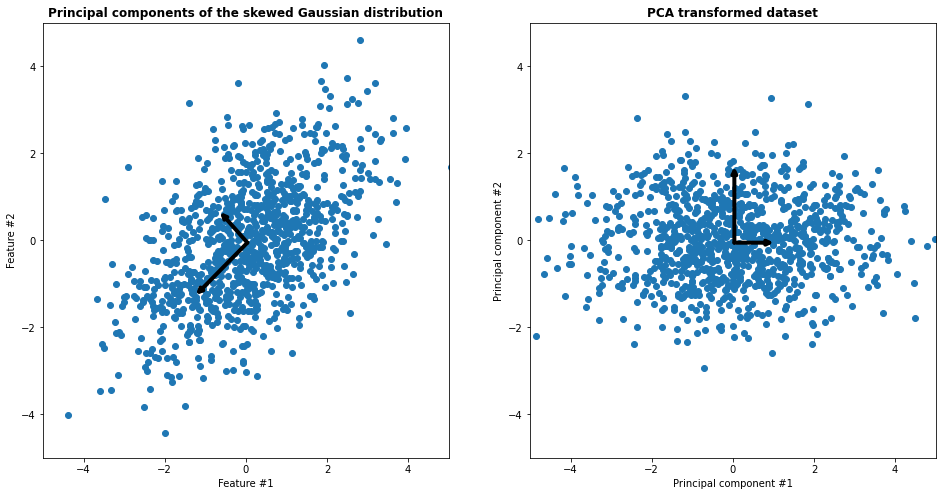

In [6]:
fig, axes = plt.subplots(1,2, figsize = (16,8))

X_mean = np.mean(X, axis = 0)

# We plot vectors from (X_mean) - i.e. the data center - to (X _mean + sqrt(eigenvalue)*eigenvector)
# We use sqrt(eigenvalue) as a scaling factor to show the relative "importance" of the eigenvectors
# But note that this has no semantic meaning/significance!

plot_data(X, "Principal components of the skewed Gaussian distribution", "Feature #1", "Feature #2", axes[0])
draw_vector(X_mean, X_mean + np.sqrt(s[0])*U[:,0], axes[0])
draw_vector(X_mean, X_mean + np.sqrt(s[1])*U[:,1], axes[0])

plot_data(X_pca, "PCA transformed dataset", "Principal component #1", "Principal component #2", axes[1])
draw_vector(X_mean, X_mean + np.sqrt(s[0])*np.array([0,1]), axes[1])
draw_vector(X_mean, X_mean + np.sqrt(s[1])*np.array([1,0]), axes[1])

<a id=pca_dim_reduction></a>
<div style="float:right;;margin:-5px 5px"><img src="../reader/assets/read_ico.png" width="42" height="42"></div>

### 2.3 Dimensionality reduction using PCA
In the previous section, we showed the basic principles of PCA. However, dimensionality reduction is obviously not very important if you only have two features. PCA becomes much more useful for datasets where there are too many features to plot in a human understandable way. In that case, we can select only a subset of the first $n$ eigenvectors of matrix $\mathbf{U}$ (principal components) to do our transformation with. This means we project the data onto fewer axes and get a lower dimensional dataset! For example, if we have a 100-dimensional dataset and we choose $n = 10$, we only take the first 10 columns of $\mathbf{U}$ and use this $\mathbf{U_{\text{reduced}}}$ to project 100 dimensions onto 10 dimensions.

We usually decide on the number $n$ as follows: we ask _how many principal components we need to retain $\geq 95\%$ of the dataset's variance._  To reiterate: in dimensionality reduction, we care about retaining as much as the data's variance as possible, while using as little dimensions as possible.

We can describe 'retained variance' with the eigenvalues of the principal components: for $n$ vectors and a $k$-dimensional dataset, the retained variance $r$ is:
\begin{equation}
r = \sum_{i=1}^{n}\lambda_i \bigg/ \sum_{i=1}^{K}\lambda_i
\end{equation}

In other words, we divide the variance that the first $n$ principal components retain by the total variance of all principal components. The variance of a principal component is represented by its eigenvalue.

### *A graphical example: cell nuclei*
Let's give an example using a high dimensional data set: we use the cell nuclei dataset from the CAD project.


In [8]:
from scipy.io import loadmat

def plot_series(images, shape = (5,5), stochastic = True):
    n,m = shape
    ix = np.random.randint(0, images.shape[-1], n*m) if stochastic else np.arange(0, n*m)
    
    fig, axs = plt.subplots(n, m, figsize=(n, m))
    axs = axs.ravel()
    for i, j in zip(range(n*m), ix):
        axs[i].imshow(images[:,:,:,j])
        axs[i].axis('off');
    
    return axs

In [9]:
# Load dataset
fn = '../data/nuclei_data.mat'
mat = loadmat(fn)

images = mat["training_images"]       # shape (24, 24, 3, 21910)
images_y = mat["training_y"]          # shape (21910, 1)

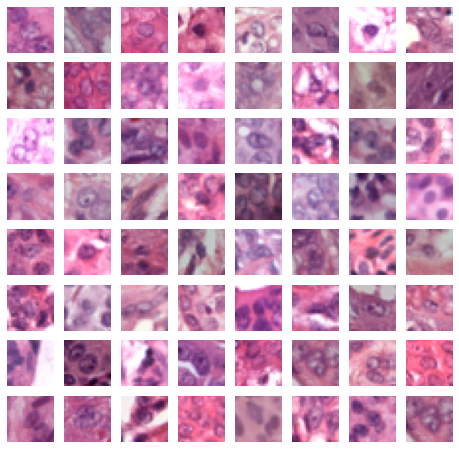

In [10]:
# Visualize - randomized, so refresh to see new nuclei!
axs = plot_series(images, shape = (8,8))

In the CAD project, you must perform linear regression on the raw pixel values of the images to predict the surface area of nuclei. Here, we don't do regression, but purely investigate how many principal components we need to properly represent this high dimensional dataset, for the purposes of dimensional reduction. Because the images are of shape $(24,24,3)$, we get a total of $24x24x3 = 1728$ features per image. As our training set consists of 21910 images, we will have a $(21910,1728)$ shaped dataset $\mathbf{X}$.

In [11]:
shapes = images.shape 
num_features = shapes[0]*shapes[1]*shapes[2]
X = images.reshape(num_features, shapes[3]).T.astype(float)
print("The shape of our dataset X is: ", X.shape)

The shape of our dataset X is:  (21910, 1728)


Let's perform PCA on our dataset and see how many principal components we need to retain 95% of the data variance.

In [12]:
X_pca, U, s = pca_transform(X)

# Every iteration i, divide variance retained in s[0:i] by total variance 
r = np.array([s[0:i].sum() / np.sum(s) for i in range(1, len(s)+1)]) 
n = np.argmax(r > 0.95)
print("The number of principal components needed to retain 95 percent data variance is: ", n+1)

The number of principal components needed to retain 95 percent data variance is:  132


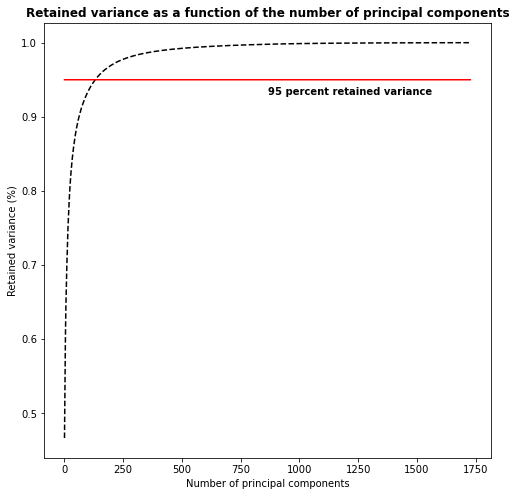

In [13]:
plt.figure(figsize = (8,8))
plt.plot(r, 'k--')
plt.plot(range(len(r)), np.ones(len(r)) * 0.95, 'r-')
plt.xlabel("Number of principal components")
plt.ylabel("Retained variance (%)")
plt.text(1728/2, 0.93, "95 percent retained variance", fontweight = "bold")
plt.title("Retained variance as a function of the number of principal components", fontweight = 'bold');

Remarkably, we only need 132 principal components (dimensions) to retain 95 percent of our data variance, even for a 1728 dimensional dataset. We can now easily reduce the dimensionality of our dataset by transforming the data with the first 132 eigenvectors. In a real scenario, we could now use this transformed dataset to perform regression (and also classification) techniques on. In general, because of the lower dimensionality, techniques will be less likely to overfit.

In [14]:
X_hat = X - np.mean(X, axis = 0)
U_reduced = U[0:132]
X_pca = U_reduced.dot(X_hat.T).T # Our new, transformed (and lower dimensional) dataset
print("The new shape of our data matrix now is: ", X_pca.shape)

The new shape of our data matrix now is:  (21910, 132)


<div style="float:right;;margin:-5px 5px"><img src="../reader/assets/read_ico.png" width="42" height="42"></div>

<a id=pca_intuitive></a>

### 2.4 Intuitive interpretations of principle components

Lastly, we show two additional intuitive interpretations of principle components.

We have also established that principle components can be thought of the orthogonal directions of variation in our dataset. However, beyond just 'direction', we can also visualize this variation in the form of an image! Consider the fact that the eigenvectors are of the shape $(1, 1728)$ and can thus be reshaped back into the original shape of the image, $(24,24,3)$. In this form, the eigenvectors represent the _principle modes of variation_ in the image. 

We visualize this with the code in the cell below. Per eigenvector, we reshape the vectors to images (and rescale the values to [0,255]). The first eigenvector (top left) is a disk, which makes sense: since our dataset depicts nuclei, typically round, centered objects, the most variation exists in that form. As we go further right and down, this variation becomes more abstract. 

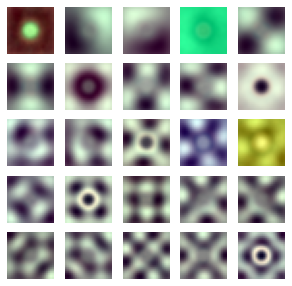

In [15]:
# From here, we use the sklearn PCA function, it's much better optimized than our own code.
sys.path.append("../code")
from sklearn.decomposition import PCA
from cad_PCA import reconstruction_demo, reshape_and_rescale

# Rescaling is necessary because the eigenvectors are not in [0,255] domain
reconstructed_ims = np.stack([reshape_and_rescale(U[:,i]) for i in range(U.shape[-1])], axis = -1)
axes = plot_series(reconstructed_ims, shape = (5,5), stochastic = False)

Second of all, we can use the eigenvectors in the matrix $\mathbf{U}$ to reconstruct our images from the transformed dataset $\mathbf{X}_{\text{PCA}}$. We simply multiply the data with $\mathbf{U}$ again, because: 

\begin{equation}
\mathbf{X_{\text{PCA}}} = \mathbf{U^T}\mathbf{\hat{X}} \\
\mathbf{X_{\text{rec}}} = \mathbf{U}\mathbf{X_{\text{PCA}}} = \mathbf{U}\mathbf{U^T}\mathbf{\hat{X}} = \mathbf{I}\mathbf{\hat{X}} \\
\end{equation}
Then we just have to add the mean back to the data ("uncentering" it), and we get back our original dataset $\mathbf{X}$.
\begin{equation}
\mathbf{X} = \mathbf{X_{\text{rec}}} + \mathbf{\bar{X}}
\end{equation}

Just like with the eigenvectors, we can reshape the individual rows of the dataset $\mathbf{X}$ back into an image. However, we can also reconstruct and reshape the images with only a subset of the eigenvectors, so with $\mathbf{U_\text{reduced}}$. In the demo below, we show the resulting images for the first 200 eigenvectors. 

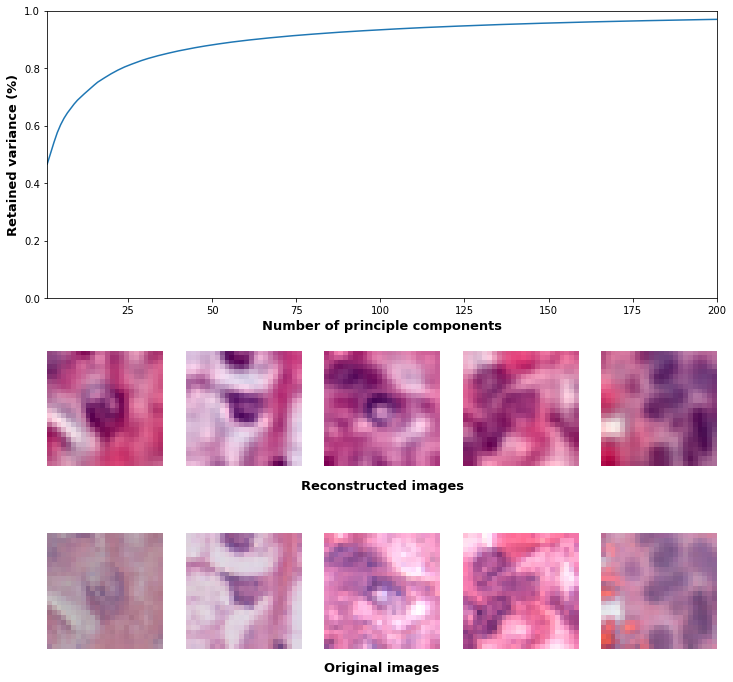

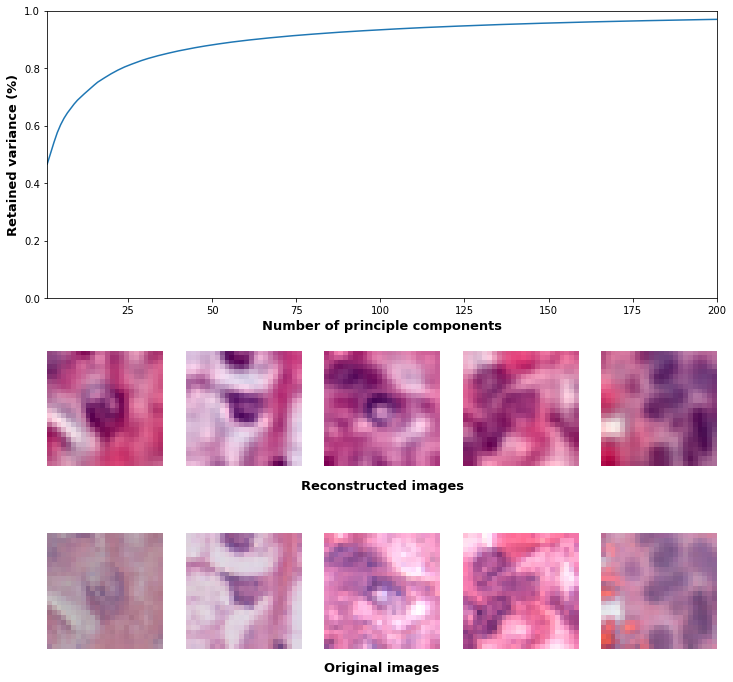

In [16]:
pca = PCA()
pca.fit(X)
reconstruction_demo(X, pca)

As you can see, as the number of principle components used to reconstruct the images with increases, the quality of the images becomes better. This is because we able to utilize more information of the dataset in the reconstruction. In effect, we observe that each principle component is a linear combination of all features of our dataset.

<a id=pca_exercises></a>

## 3. Principal component analysis (exercises)

<div style="float:right;;margin:-5px 5px"><img src="../reader/assets/todo_ico.png" width="42" height="42"></div>

### *Exercise 3.1*:
Use the following:

```python
generate_gaussian_data(100, [0, 0], [0, 0], [[3, 1],[1, 1]], [[3, 1],[1, 1]])
```

to generate a dataset with correlated features. Calculate the mean and covariance matrix of the data using `mean` and `cov` and compare them to the parameters you used as input. Write your implementation in `covariance_matrix_test()` in `SECTION 2` of the `segmentation_tests.py` module.

In [4]:
%matplotlib inline
import sys
sys.path.append("../code")
from segmentation_tests import covariance_matrix_test
X, Y, sigma = covariance_matrix_test()

Mean:
[-0.20086499 -0.04288037]
Covariance matrix:
[[3.42013403 0.48687568]
 [0.48687568 0.59369576]]


<div style="float:right;;margin:-5px 5px"><img src="../reader/assets/question_ico.png" width="42" height="42"></div>

### *Question 3.1*:
Is there a difference? How could you increase or decrease this difference?

<font style="color:red">Type your answer here</font>


<div style="float:right;;margin:-5px 5px"><img src="../reader/assets/todo_ico.png" width="42" height="42"></div>

### *Exercise 3.2*:
Compute the eigenvectors and eigenvalues of the covariance matrix using:

```python
w, v = np.linalg.eig(cov)
````

(the column `v[:,i]` is the eigenvector corresponding to the eigenvalue `w[i]`).

Inspect the eigenvectors and eigenvalues. What two properties can you name about the eigenvectors? How can you verify these properties (describe the operations, or give a line of Python code). For the eigenvalues, which eigenvalue is the largest and which is the smallest?

You can sort the eigenvalues and eigenvectors as follows:

```python
ix = np.argsort(w)[::-1] #Find ordering of eigenvalues
w = w[ix] #Reorder eigenvalues
v = v[:, ix] #Reorder eigenvectors
```

Write your implementation in `eigen_vecval_test()` in `SECTION 2` of the `segmentation_tests.py` module.

In [2]:
%matplotlib inline
import sys
sys.path.append("../code")
from segmentation_tests import eigen_vecval_test
v, w = eigen_vecval_test(sigma)

Eigenvalues w:
[4.07875811 0.64964702]
Eigenvectors v:
[[ 0.97908048 -0.2034734 ]
 [ 0.2034734   0.97908048]]
Order v:
[0 1]
Reordered eigenvalues v:
[4.07875811 0.64964702]
Reordered eigenvectors v:
[[ 0.97908048 -0.2034734 ]
 [ 0.2034734   0.97908048]]
Checking results:
Dot procuct of first eigenvector with itself:
1.0000000000000002
Dot procuct of the two eigenvectors:
0.0


<div style="float:right;;margin:-5px 5px"><img src="../reader/assets/todo_ico.png" width="42" height="42"></div>

### *Exercise 3.3*:
Rotate the data using `v`. This is similar to what you did in the registration project, only now instead of getting the angle of rotation, `v` is already the rotation matrix.

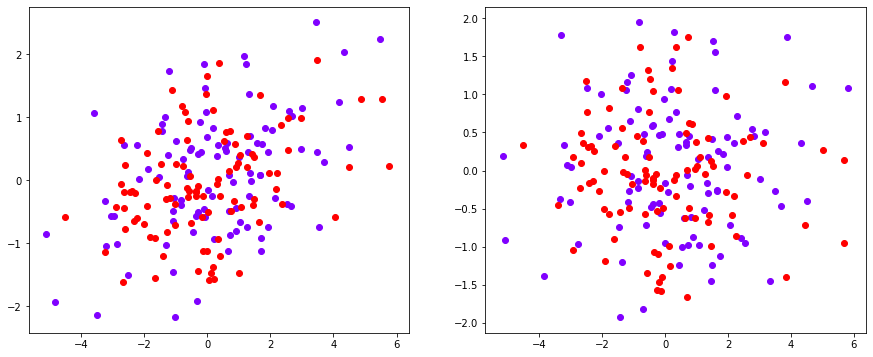

In [3]:
%matplotlib inline
import sys
sys.path.append("../code")
from segmentation_tests import rotate_using_eigenvectors_test
X_rotated = rotate_using_eigenvectors_test(X, Y, v)

<div style="float:right;;margin:-5px 5px"><img src="../reader/assets/question_ico.png" width="42" height="42"></div>

### *Question 3.2*:
In most literature you will see the notation $v^{T}*X$, but this will not work on our dataset because of how the dataset is defined (rows = samples, columns = dimensions). Instead use $X_{pca}=v^{T}*X^{T}$ and $X_{pca}=X_{pca}^{T}$. What can you say about the covariance matrix of `Xpca`?

<font style="color:red">Type your answer here</font>

<div style="float:right;;margin:-5px 5px"><img src="../reader/assets/todo_ico.png" width="42" height="42"></div>

### *Exercise 3.4*:
Complete the missing functionality in the function `mypca()` in `SECTION 2` of the `segmentation.py` module. Test the function by running the `test_mypca()` script located in the `segmentation_tests.py` module. This will plot the original data, and the data after `test_mypca()` is applied. Here is how the result might look:

<img src="../reader/assets/test_mypca.png" width="800" align="center"/>


[[0.90223878]
 [1.        ]]


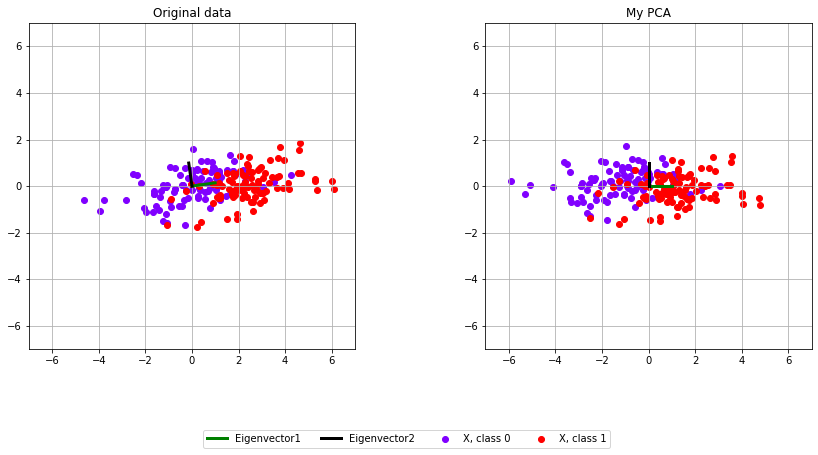

In [5]:
%matplotlib inline
import sys
sys.path.append("../code")
from segmentation_tests import test_mypca

test_mypca()

<div style="float:right;;margin:-5px 5px"><img src="../reader/assets/question_ico.png" width="42" height="42"></div>

### *Question 3.3*:
You might have noticed when editing `mypca()` that there is an additional output, `fraction_variance`. This vector stores how much variance is accounted for by the first, first two, first three etc principal components. How much variance is the first principal component responsible for in the Gaussian data you just generated? How would you need to modify the covariance matrix of the data, in order to decrease the amount of variance in the first principal component? You can test your hypothesis by modifying the properties of the Gaussian data created at the start of `test_mypca()`.

Note that not any matrix is a valid covariance matrix so if you just enter random numbers you are likely to get an error. To start, the matrix needs to be symmetric, and the diagonal values need to be positive. Furthermore, the covariance cannot be large if the variance is small.  You can read about how to verify this here: [https://math.stackexchange.com/questions/1522397/how-to-tell-is-a-matrix-is-a-covariance-matrix](https://math.stackexchange.com/questions/1522397/how-to-tell-is-a-matrix-is-a-covariance-matrix).

<font style="color:red">Type your answer here</font>